# 摘要

# 理论模型

大豆提油套利的模式主要是在美豆和国内豆粕豆油间展开，即进口美豆后在国内压榨出售。主要的关注点是美豆的成本以及豆粕豆油的价格。

美豆的到厂成本如下：

大船舱底完税价格 = 到岸价格 * (1+增值税) * (1+关税) * 美元兑人民币汇率

进口大豆到厂成本 = 大船舱底完税价格 + 港杂费 + 运费

大豆压榨的技术参数较为稳定，国内大豆压榨工艺的油粕产出比例为 19.2% 豆油，78.6% 豆粕，以及 2.2% 的损耗。

进口大豆压榨的利润公式为：

进口大豆压榨利润 = 0.786 * 豆粕价格 + 0.192 * 豆油价格 - 进口大豆到厂成本 - 其他费用

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2()

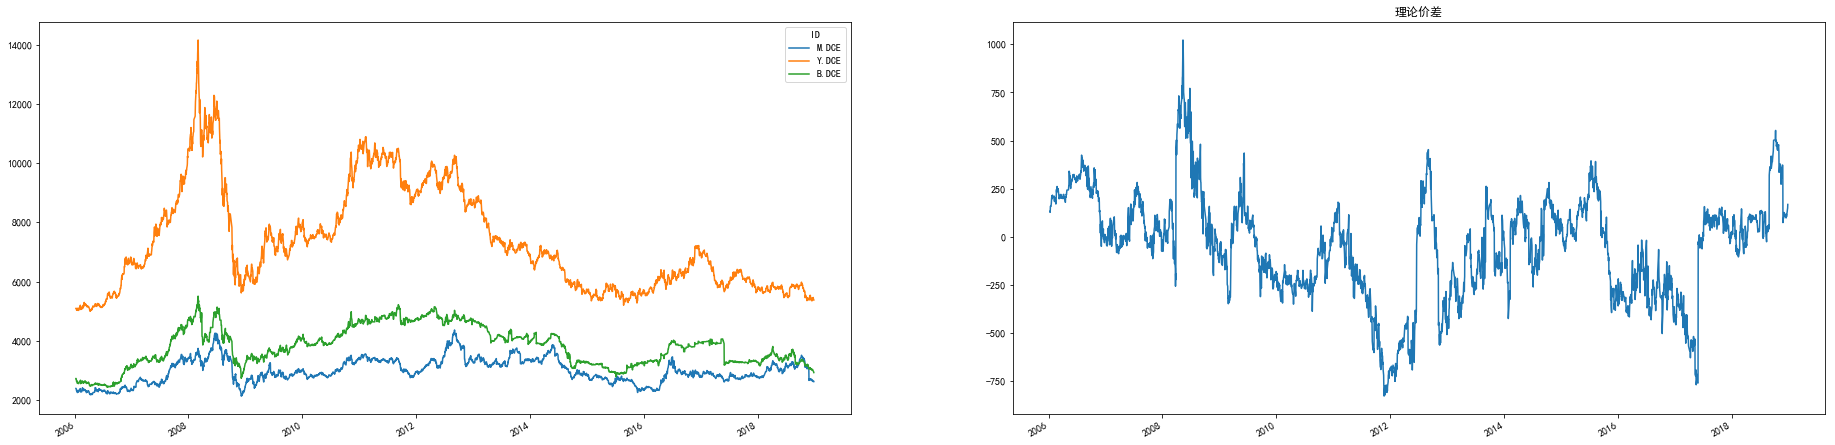

In [9]:
# 参数设置和数据准备
# IDs = ["M01.DCE", "Y01.DCE", "B01.DCE"]# 豆粕, 豆油, 豆2连一合约
IDs = ["M.DCE", "Y.DCE", "B.DCE"]# 豆粕, 豆油, 豆2主力合约
TheoryHedgeRatio = np.array([0.786, 0.192, -1])# 理论对冲比例
StartDT = dt.datetime(2006, 1, 9)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid="DCE", start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=IDs, dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=[PriceFactor], ids=IDs, dts=DTs).iloc[0]
WDB.disconnect()

# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
(CCPrice * TheoryHedgeRatio).sum(axis=1).plot(kind="line", ax=Axes[1], title="理论价差");

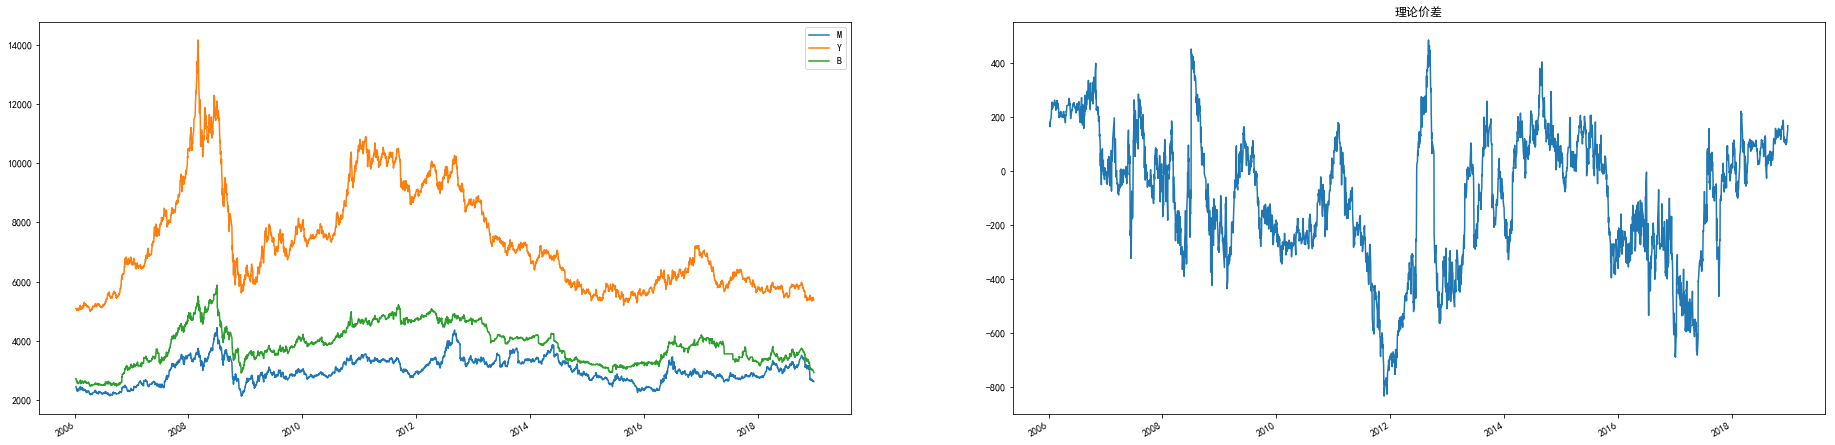

In [10]:
# 使用对齐交割月的价格数据
import re
Exchange = "DCE"
    BenchmarkID = "·.DCE"# 作为标准的主力合约
Codes = ["M", "Y", "B"]# 合约代码
ExchangeSuffix = ["DCE", "DCE", "DCE"]# 交易所后缀
TheoryHedgeRatio = np.array([0.786, 0.192, -1])# 理论对冲比例
StartDT = dt.datetime(2006, 1, 9)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

# 以焦炭的主力合约为准
WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[BenchmarkID], dts=DTs).iloc[0,:,:]
for i, iCode in enumerate(Codes):
    FutureIDMap[iCode] = FutureIDMap.iloc[:, 0].apply(lambda x: iCode+re.sub("\D", "", x)+"."+ExchangeSuffix[i])
FutureIDMap.pop(BenchmarkID)
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect()

# 生成连续合约的价格
CCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_type="价格不变") for iID in FutureIDMap.columns}
CCPrice = pd.DataFrame(CCPrice).loc[:, FutureIDMap.columns]
# 对连续合约的价格进行展期调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in FutureIDMap.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, FutureIDMap.columns]

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes[0])
(CCPrice * TheoryHedgeRatio).sum(axis=1).plot(kind="line", ax=Axes[1], title="理论价差");

In [11]:
# --------平稳性检验--------
# ADF 检验
for i, iID in enumerate(CCPrice.columns):
    ADFTest = sm.tsa.stattools.adfuller(CCPrice.values[:, i], regression='c', autolag="BIC")
    print(("----------- %s价格 ADF Test ----------" % iID),
          ("Statistic : %f" % ADFTest[0]),
          ("pvalue : %f" % ADFTest[1]),
          ("usedlag : %d" % ADFTest[2]), sep="\n")
for i, iID in enumerate(CCPrice.columns):
    ADFTest = sm.tsa.stattools.adfuller(np.diff(CCPrice.values[:, i]), regression='c', autolag="BIC")
    print(("----------- Diff(%s价格, 1) ADF Test ----------" % iID),
          ("Statistic : %f" % ADFTest[0]), 
          ("pvalue : %f" % ADFTest[1]), 
          ("usedlag : %d" % ADFTest[2]), sep="\n")

----------- M价格 ADF Test ----------
Statistic : -3.047707
pvalue : 0.030673
usedlag : 0
----------- Y价格 ADF Test ----------
Statistic : -1.726164
pvalue : 0.417685
usedlag : 0
----------- B价格 ADF Test ----------
Statistic : -2.078434
pvalue : 0.253274
usedlag : 2
----------- Diff(M价格, 1) ADF Test ----------
Statistic : -57.356130
pvalue : 0.000000
usedlag : 0
----------- Diff(Y价格, 1) ADF Test ----------
Statistic : -37.554389
pvalue : 0.000000
usedlag : 1
----------- Diff(B价格, 1) ADF Test ----------
Statistic : -60.628999
pvalue : 0.000000
usedlag : 0


----------- M-Y-B Cointegration Johansen Test: r<=0 -----------
Trace Statistic: 41.345034
Critical Values (90%, 95%, 99%): [27.0669 29.7961 35.4628]
Maximum Eigenvalue Statistic Statistic: 20.447434
Critical Values (90%, 95%, 99%): [18.8928 21.1314 25.865 ]
----------- M-Y-B Cointegration Johansen Test: r<=1 -----------
Trace Statistic: 20.897600
Critical Values (90%, 95%, 99%): [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic: 17.417674
Critical Values (90%, 95%, 99%): [12.2971 14.2639 18.52  ]
----------- M-Y-B Cointegration Johansen Test: r<=2 -----------
Trace Statistic: 3.479925
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic: 3.479925
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
对冲比例: [ 1.          0.2563859  -1.12115243]


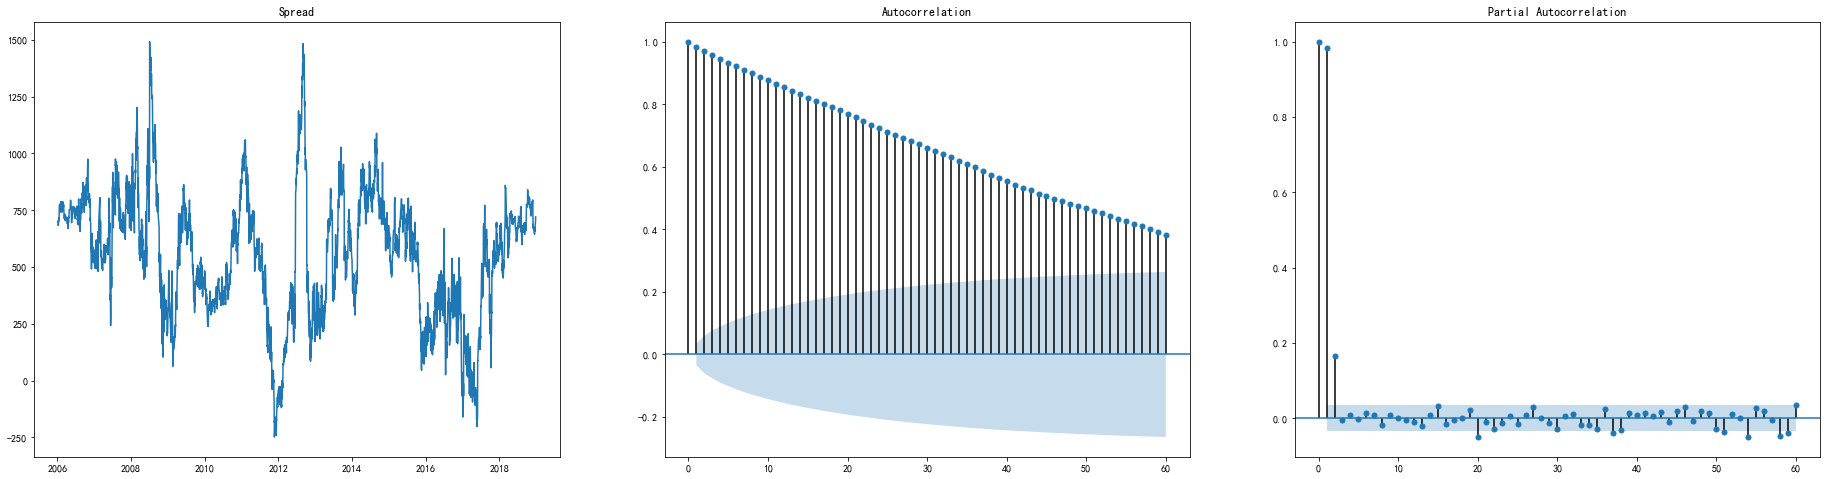

In [12]:
# --------协整检验--------
CointJohansenTest = sm.tsa.var.vecm.coint_johansen(CCPrice.values, det_order=0, k_ar_diff=1)
for i in range(CointJohansenTest.lr1.shape[0]):
    print(("----------- %s Cointegration Johansen Test: r<=%d -----------" % ("-".join(CCPrice.columns), i)),
          ("Trace Statistic: %f" % (CointJohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic: %f" % (CointJohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%): %s" % (str(CointJohansenTest.cvm[i]), )), sep="\n")

HedgeRatio = CointJohansenTest.evec[:, 0] / CointJohansenTest.evec[0, 0]
print("对冲比例: %s" % str(HedgeRatio))

Spread = (CCPrice * HedgeRatio).sum(axis=1)

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(Spread)
Axes[0].set_title("Spread")
sm.graphics.tsa.plot_acf(Spread, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(Spread, lags=60, ax=Axes[2]);

HalfLife: 38.868499


,0
起始时点,2006-01-09 00:00:00
结束时点,2018-12-28 00:00:00
时点数,3159
总收益率,2.45277
年化收益率,0.100211
年化波动率,0.0716552
Sharpe比率,1.39852
胜率,0.65717
最大回撤率,0.123819
最大回撤开始时点,2012-06-18 00:00:00


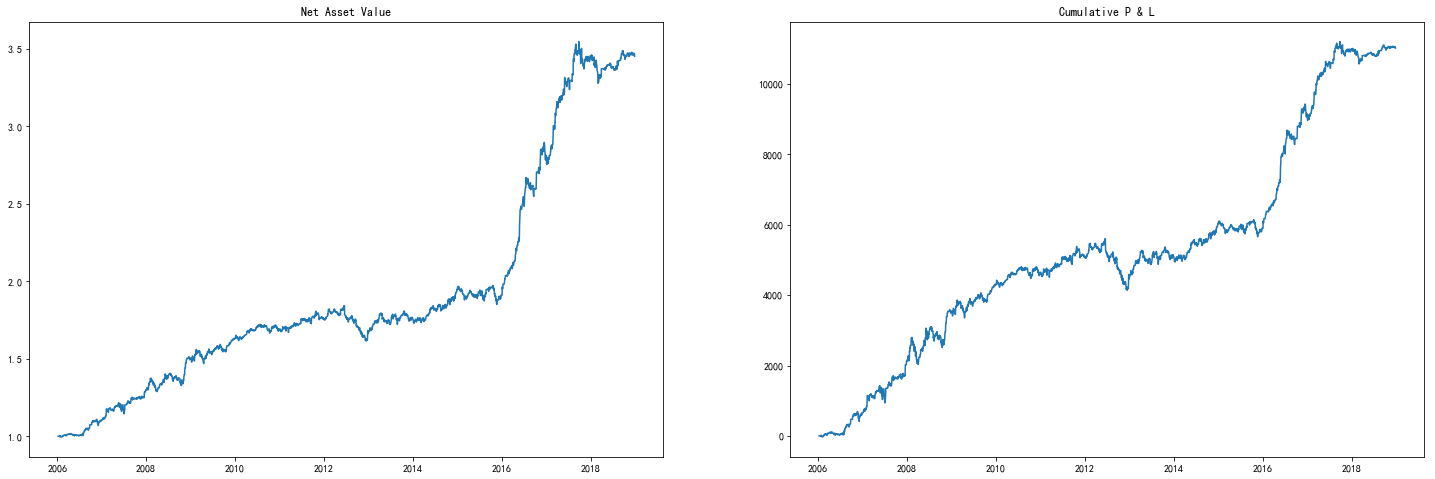

In [15]:
# --------Spread 策略--------
EntryThreshold, ExitThreshold = 1, 0
# NumRatio = TheoryHedgeRatio
NumRatio = HedgeRatio

# 生成信号
Spread = (CCPrice * NumRatio).sum(axis=1)
HalfLife = - np.log(2) / sm.OLS(np.diff(Spread.values), sm.add_constant(Spread.values[:-1], prepend=False)).fit().params[0]
print("HalfLife: %f" % HalfLife)
LookBack = 10
# LookBack = max(5, int(round(HalfLife)))
Zscore = (Spread - Spread.rolling(LookBack).mean()) / Spread.rolling(LookBack).cov()**0.5
NumUnits = np.full(shape=(CCPrice.shape[0], ), fill_value=np.nan)
# 空头信号
Mask = (Zscore.values>EntryThreshold)
NumUnits[Mask] = -1
# 多头信号
Mask = (Zscore.values<-EntryThreshold)
NumUnits[Mask] = 1
# 平仓信号
PreNumUnits = pd.Series(NumUnits).fillna(method="pad").values
NumUnits[(PreNumUnits==1) & (Zscore.values>=-ExitThreshold)] = 0
NumUnits[(PreNumUnits==-1) & (Zscore.values<=ExitThreshold)] = 0
# 填充缺失
NumUnits[0] = (0 if pd.isnull(NumUnits[0]) else NumUnits[0])
NumUnits = pd.Series(NumUnits).fillna(method="pad").values
# 策略回测
NumUnits = NumUnits.reshape((NumUnits.shape[0],1)).repeat(NumRatio.shape[0], axis=1) * NumRatio
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits * CCPrice.values / AdjCCPrice.values, AdjCCPrice.values)
Return, PNL = pd.Series(Return, index=CCPrice.index), pd.DataFrame(PNL, index=CCPrice.index, columns=CCPrice.columns)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");